# 🚀 Snorkel Lab Implementation: Data Labeling

### Task: Sentiment Classification

We use a subset of the [IMDb movie review dataset](https://ai.stanford.edu/~amaas/data/sentiment/).
Each data point is a full review of a movie, and the task is to determine whether the author wrote a

* **`NEGATIVE`**: review expressing an overall negative opinion, or
* **`POSITIVE`**: review expressing an overall positive opinion

To keep the tutorial lightweight on disk and CPU, we work with a stratified sample of **5,000** reviews drawn from the full dataset.

For example, the following reviews are `POSITIVE`:

        "A wonderful little production... a masterful production about one of the great masters of comedy and his life."

        "This was the most I'd laughed at one of Woody's comedies in years... a great comedy to go see with friends."

and these are `NEGATIVE`:

        "Basically there's a family where a little boy thinks there's a zombie in his closet... suddenly, Jake decides to become Rambo and kill the zombie."

        "This movie is slower than a soap opera... 3 out of 10 just for the well playing parents."


### Data Splits in Snorkel

We split our data into two sets:
* **Training Set**: The largest split of the dataset, and the one without any ground truth ("gold") labels.
We will generate labels for these data points with weak supervision.
* **Test Set**: A small, standard held-out blind hand-labeled set for final evaluation of our classifier. This set should only be used for final evaluation, _not_ error analysis.

Note that in more advanced production settings, we will often further split up the available hand-labeled data into a _development split_, for getting ideas to write labeling functions, and a _validation split_ for e.g. checking our performance without looking at test set scores, hyperparameter tuning, etc.  These splits are used in some of the other advanced tutorials, but omitted for simplicity here.

## 1. Loading Data

We load the IMDb reviews dataset and create Pandas DataFrame objects for the train and test sets.
DataFrames are extremely popular in Python data analysis workloads, and Snorkel provides native support
for several DataFrame-like data structures, including Pandas, Dask, and PySpark.
For more information on working with Pandas DataFrames, see the [Pandas DataFrame guide](https://pandas.pydata.org/pandas-docs/stable/user_guide/dsintro.html).

Each DataFrame consists of the following fields:
* **`text`**: Raw text content of the movie review
* **`label`**: Whether the review is `POSITIVE` (1), `NEGATIVE` (0), or `UNKNOWN/ABSTAIN` (-1) when generated by LFs

We start by loading the full CSV export of the IMDb dataset, downsampling it to 5,000 stratified examples for faster experimentation, and then creating randomized train and test splits from that subset.


This next cell takes care of some notebook-specific housekeeping.
You can ignore it.

In [63]:
%matplotlib inline

import os

# Turn off TensorFlow logging messages
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

# For reproducibility
os.environ["PYTHONHASHSEED"] = "0"

If you want to display all review text untruncated, change `DISPLAY_ALL_TEXT` to `True` below.

In [64]:
import pandas as pd

DISPLAY_ALL_TEXT = False

pd.set_option("display.max_colwidth", 0 if DISPLAY_ALL_TEXT else 50)

This next cell makes sure a spaCy English model is downloaded.
If this is your first time downloading this model, restart the kernel after executing the next cell.

In [65]:
# Download the spaCy english model
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 64.1 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: pip install --upgrade pip
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [66]:
from pathlib import Path
from sklearn.model_selection import train_test_split

MAX_DATASET_SIZE = 5000

data_path = Path("Lab3_assignment/data/IMDB Dataset.csv")

df = pd.read_csv("/Users/raghavg/Desktop/MLOps/Lab3_assignment/data/IMDB Dataset.csv")
df["text"] = (
    df["review"]
    .str.replace("<br />", " ", regex=False)
    .str.replace("<br/>", " ", regex=False)
    .str.replace("<br>", " ", regex=False)
    .str.strip()
)
df["label"] = df["sentiment"].map({"negative": 0, "positive": 1})
df = df[["text", "label"]]

if len(df) > MAX_DATASET_SIZE:
    df, _ = train_test_split(
        df,
        train_size=MAX_DATASET_SIZE,
        stratify=df["label"],
        random_state=42,
    )
    df = df.reset_index(drop=True)

df_train, df_test = train_test_split(
    df, test_size=0.2, stratify=df["label"], random_state=42
)
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

Y_test = df_test.label.values


The class distribution varies slightly between `POSITIVE` and `NEGATIVE`, but they're approximately class-balanced.

In [67]:
# For clarity, we define constants to represent the class labels for negative, positive, and abstaining.
ABSTAIN = -1
NEGATIVE = 0
POSITIVE = 1

## 2. Writing Labeling Functions (LFs)

### A gentle introduction to LFs

**Labeling functions (LFs) help users encode domain knowledge and other supervision sources programmatically.**

LFs are heuristics that take as input a data point and either assign a label to it (in this case, `NEGATIVE` or `POSITIVE`) or abstain (don't assign any label). Labeling functions can be *noisy*: they don't have perfect accuracy and don't have to label every data point.
Moreover, different labeling functions can overlap (label the same data point) and even conflict (assign different labels to the same data point). This is expected, and we demonstrate how we deal with this later.

Because their only requirement is that they map a data point a label (or abstain), they can wrap a wide variety of forms of supervision. Examples include, but are not limited to:
* *Keyword searches*: looking for specific words in a sentence
* *Pattern matching*: looking for specific syntactical patterns
* *Third-party models*: using an pre-trained model (usually a model for a different task than the one at hand)
* *Distant supervision*: using external knowledge base
* *Crowdworker labels*: treating each crowdworker as a black-box function that assigns labels to subsets of the data

### Recommended practice for LF development

Typical LF development cycles include multiple iterations of ideation, refining, evaluation, and debugging.
A typical cycle consists of the following steps:

1. Look at examples to generate ideas for LFs
1. Write an initial version of an LF
1. Spot check its performance by looking at its output on data points in the training set (or development set if available)
1. Refine and debug to improve coverage or accuracy as necessary

Our goal for LF development is to create a high quality set of training labels for our unlabeled dataset,
not to label everything or directly create a model for inference using the LFs.
The training labels are used to train a separate discriminative model (in this case, one which just uses the review text) in order to generalize to new, unseen data points.
Using this model, we can make predictions for data points that our LFs don't cover.

We'll walk through the development of two LFs using basic analysis tools in Snorkel, then provide a full set of LFs that we developed for this tutorial.

### a) Exploring the training set for initial ideas

We'll start by looking at 20 random data points from the `train` set to generate some ideas for LFs.

In [68]:
df_train.head()

,text,label
0,The three names that mean the most to this fil...,1
1,"""Let me ask you one more question"" Ha ! what a...",1
2,This was playing at our theater in Amsterdam a...,1
3,A different look at horror. The styling differ...,0
4,This movie is a waste of film stock. Do you be...,0


In [69]:
df_train[["text", "label"]].sample(20, random_state=2)

,text,label
3846,This film has an excellent premise and is real...,1
848,"I have always been a huge fan of ""Homicide: Li...",1
1658,The Israeli/Palestinian conflict persists and ...,1
3415,John Cassavetes is on the run from the law. He...,1
3678,Were it not for the fact that this came as a 2...,0
3088,Having looked at some of the other comments he...,1
218,This film would be considered controversial to...,1
2311,"I walked into a book store in Brentwood, Tenne...",0
1733,This was recommended to me by a friend that sa...,1
998,Don't you ever miss the good old days when Dis...,1


One dominant pattern in the most enthusiastic reviews (which we might know from prior domain experience, or from inspecting a few training data points) is the use of the phrase "loved it" (e.g. "absolutely loved it").
Let's start with that.

### b) Writing an LF to identify enthusiastic reviews that mention `"loved it"`

Labeling functions in Snorkel are created with the
[`@labeling_function` decorator](https://snorkel.readthedocs.io/en/master/packages/_autosummary/labeling/snorkel.labeling.labeling_function.html).
The [decorator](https://realpython.com/primer-on-python-decorators/) can be applied to _any Python function_ that returns a label for a single data point.

Let's start developing an LF to catch instances of reviewers explicitly stating that they loved the movie.
We'll start by just looking for the exact string `"loved it"` in the text, and see how that compares to looking for just `"love"` in the text.
For the two versions of our rule, we'll write a Python function over a single data point that express it, then add the decorator.

In [70]:
from snorkel.labeling import labeling_function


@labeling_function()
def mentions_love(x):
    return POSITIVE if "love" in x.text.lower() else ABSTAIN


@labeling_function()
def mentions_loved_it(x):
    return POSITIVE if "loved it" in x.text.lower() else ABSTAIN

In [71]:
import os
import numpy as np
from snorkel.labeling import PandasLFApplier

os.environ.setdefault("JOBLIB_MULTIPROCESSING", "0")

def apply_lfs_sequentially(
    lfs,
    df,
    *,
    batch_size=512,
    keep_cols=None,
    show_progress=False,
):
    """Apply labeling functions in batches to cap temporary disk usage."""
    if keep_cols is not None:
        keep_cols = tuple(keep_cols)

    applier = PandasLFApplier(lfs=lfs)
    label_chunks = []
    total = len(df)

    for start in range(0, total, batch_size):
        stop = min(start + batch_size, total)
        batch = df.iloc[start:stop]
        if keep_cols is not None:
            batch = batch.loc[:, list(keep_cols)]

        label_matrix = applier.apply(df=batch, progress_bar=False)
        label_chunks.append(label_matrix)

        if show_progress:
            print(f"Applied LFs to rows {start}:{stop} of {total}")

    if not label_chunks:
        return np.zeros((0, len(lfs)), dtype=int)

    return np.vstack(label_chunks)


To apply one or more LFs that we've written to a collection of data points, we use an
[`LFApplier`](https://snorkel.readthedocs.io/en/master/packages/_autosummary/labeling/snorkel.labeling.LFApplier.html).
Because our data points are represented with a Pandas DataFrame in this tutorial, we use the
[`PandasLFApplier`](https://snorkel.readthedocs.io/en/master/packages/_autosummary/labeling/snorkel.labeling.PandasLFApplier.html).
Correspondingly, a single data point `x` that's passed into our LFs will be a [Pandas `Series` object](https://pandas.pydata.org/pandas-docs/stable/reference/series.html).

It's important to note that these LFs will work for any object with an attribute named `text`, not just Pandas objects.
Snorkel has several other appliers for different data point collection types which you can browse in the [API documentation](https://snorkel.readthedocs.io/en/master/packages/labeling.html).

The output of the `apply(...)` method is a ***label matrix***, a fundamental concept in Snorkel.
It's a NumPy array `L` with one column for each LF and one row for each data point, where `L[i, j]` is the label that the `j`th labeling function output for the `i`th data point.
We'll create a label matrix for the `train` set.

In [72]:
lfs = [mentions_loved_it, mentions_love]
L_train = apply_lfs_sequentially(lfs=lfs, df=df_train, keep_cols=("text",))


In [73]:
L_train

array([[-1, -1],
       [-1, -1],
       [-1, -1],
       ...,
       [-1,  1],
       [-1, -1],
       [-1, -1]], shape=(4000, 2))

### c) Evaluate performance on training set

We can easily calculate the coverage of these LFs (i.e., the percentage of the dataset that they label) as follows:

In [74]:
coverage_mentions_loved_it, coverage_mentions_love = (L_train != ABSTAIN).mean(axis=0)
print(f"mentions_loved_it coverage: {coverage_mentions_loved_it * 100:.6f}%")
print(f"mentions_love coverage: {coverage_mentions_love * 100:.6f}%")

mentions_loved_it coverage: 1.200000%
mentions_love coverage: 25.600000%


Lots of statistics about labeling functions &mdash; like coverage &mdash; are useful when building any Snorkel application.
So Snorkel provides tooling for common LF analyses using the
[`LFAnalysis` utility](https://snorkel.readthedocs.io/en/master/packages/_autosummary/labeling/snorkel.labeling.LFAnalysis.html).
We report the following summary statistics for multiple LFs at once:

* **Polarity**: The set of unique labels this LF outputs (excluding abstains)
* **Coverage**: The fraction of the dataset the LF labels
* **Overlaps**: The fraction of the dataset where this LF and at least one other LF label
* **Conflicts**: The fraction of the dataset where this LF and at least one other LF label and disagree
* **Correct**: The number of data points this LF labels correctly (if gold labels are provided)
* **Incorrect**: The number of data points this LF labels incorrectly (if gold labels are provided)
* **Empirical Accuracy**: The empirical accuracy of this LF (if gold labels are provided)

For *Correct*, *Incorrect*, and *Empirical Accuracy*, we don't want to penalize the LF for data points where it abstained.
We calculate these statistics only over those data points where the LF output a label.
**Note that in our current setup, we can't compute these statistics because we don't have any ground-truth labels (other than in the test set, which we cannot look at). Not to worry—Snorkel's `LabelModel` will estimate them without needing any ground-truth labels in the next step!**

In [75]:
from snorkel.labeling import LFAnalysis

LFAnalysis(L=L_train, lfs=lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
mentions_loved_it,0,[1],0.012,0.012,0.0
mentions_love,1,[1],0.256,0.012,0.0


We might want to pick the broader `mentions_love` rule, since it has higher coverage. Let's take a look at 10 random `train` set data points where `mentions_love` labeled `POSITIVE` to see if it matches our intuition or if we can identify some false positives.

In [76]:
df_train.iloc[L_train[:, 1] == POSITIVE].sample(10, random_state=1)

,text,label
3230,"In this swimming pool, this pond, there are wa...",1
3089,"Disney, the film name that once stood for all ...",1
1919,I don't remember when I first heard about this...,1
3187,When the noble Hanabusa clan is decimated by t...,1
3345,This would have been my number one movie of th...,1
428,I was in a bad frame of mind when I first saw ...,1
112,This is as good as it gets. This is six episo...,1
3855,"First of all, I too was expecting another Hero...",0
2839,How does a Scotsman in a kilt make love in the...,0
3054,I guess this is in the public domain as its ou...,0


No clear false positives here, but many look like they could be labeled by `mentions_loved_it` as well.

In [77]:
from snorkel.analysis import get_label_buckets

buckets = get_label_buckets(L_train[:, 0], L_train[:, 1])
df_train.iloc[buckets[(ABSTAIN, POSITIVE)]].sample(10, random_state=1)

,text,label
3835,"Frankly, after Cotton club and Unfaithful, it ...",0
2909,The original The Man Who Knew Too Much brought...,1
2138,"This has to be, hands down, hats off, one of t...",1
17,I would rate this film high on my list of Ingr...,1
1063,While filming an 80's horror movie called 'Hot...,0
1433,EXCUSE ME!!! HellOOOOOOOOOO!!!!!!!!!!! CUBA GO...,1
2729,Dan Finnerty and the Dan Band are so-o-o-o-o-o...,1
677,"On 24 October 1955, the hard-work geologist of...",1
3984,"(spoilers) Horrifyingly enough, I have actuall...",0
710,"I quote below words from my favor writer, Paul...",1


Most of these seem like small variations of "loved it", like "love it" or "love this". Can we get the best of both worlds?

### d) Balance accuracy and coverage

Let's see if we can use regular expressions to capture phrases such as "not really good" or "not worth it" to complement our keyword rules.

In [78]:
import re


@labeling_function()
def regex_not_good(x):
    return NEGATIVE if re.search(r"not\s+(really\s+)?(good|great|worth)", x.text, flags=re.I) else ABSTAIN

Again, let's generate our label matrices and see how we do.

In [79]:
lfs = [mentions_loved_it, mentions_love, regex_not_good]
L_train = apply_lfs_sequentially(lfs=lfs, df=df_train, keep_cols=("text",))


In [80]:
LFAnalysis(L=L_train, lfs=lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
mentions_loved_it,0,[1],0.012,0.01200,0.00000
mentions_love,1,[1],0.256,0.01475,0.00275
regex_not_good,2,[0],0.015,0.00275,0.00275


We've split the difference in `train` set coverage—this looks promising!
Let's verify that we corrected our false positive from before.

To understand the coverage difference between `mentions_love` and `regex_not_good`, let's take a look at 10 data points from the `train` set. Remember: coverage is only helpful when it does not introduce too many false positives.

In [81]:
buckets = get_label_buckets(L_train[:, 1], L_train[:, 2])
df_train.iloc[buckets[(POSITIVE, ABSTAIN)]].sample(10, random_state=1)

,text,label
3640,I love this film...! I've seen it 1000 x on dv...,1
2440,It's too bad iameracing wants to deny the real...,1
1217,"How truly friendly, charming and cordial is th...",1
1982,I don't see that much wrong with this movie. G...,1
3851,It's a long time ago I saw this movie and stil...,0
1027,I enjoyed this movie a lot. I thought that the...,1
2827,A deplorable social condition triggers off the...,1
3615,The movie was very sweet and heartwarming! I c...,1
1368,Reading some of the other reviews of this film...,1
215,"Loved the shots of airports -- Dallas, Phoenix...",1


Most of these are POSITIVE, but a good number are false positives.
**To keep precision high (while not sacrificing much in terms of coverage), we'd choose our regex-based rule.**

### e) Writing an LF that uses a third-party model

The LF interface is extremely flexible, and can wrap existing models.
A common technique is to use a commodity model trained for other tasks that are related to, but not the same as, the one we care about.

For example, the [TextBlob](https://textblob.readthedocs.io/en/dev/index.html) tool provides a pretrained sentiment analyzer.
Our task uses that same polarity signal, but we may want to set thresholds tailored to our dataset for positive and negatives.

**A brief intro to `Preprocessor`s**

A [Snorkel `Preprocessor`](https://snorkel.readthedocs.io/en/master/packages/_autosummary/preprocess/snorkel.preprocess.Preprocessor.html#snorkel.preprocess.Preprocessor)
is constructed from a black-box Python function that maps a data point to a new data point.
`LabelingFunction`s can use `Preprocessor`s, which lets us write LFs over transformed or enhanced data points.
We add the [`@preprocessor(...)` decorator](https://snorkel.readthedocs.io/en/master/packages/_autosummary/preprocess/snorkel.preprocess.preprocessor.html)
to preprocessing functions to create `Preprocessor`s.
`Preprocessor`s also have extra functionality, such as memoization
(i.e. input/output caching, so it doesn't re-execute for each LF that uses it).

We'll start by creating a `Preprocessor` that runs `TextBlob` on our reviews, then extracts the polarity and subjectivity scores.

In [82]:
from snorkel.preprocess import preprocessor
from textblob import TextBlob


@preprocessor(memoize=False)
def textblob_sentiment(x):
    scores = TextBlob(x.text)
    x.polarity = scores.sentiment.polarity
    x.subjectivity = scores.sentiment.subjectivity
    return x

We can now pick a reasonable threshold and write a corresponding labeling function (note that it doesn't have to be perfect as the `LabelModel` will soon help us estimate each labeling function's accuracy and reweight their outputs accordingly):

In [83]:
@labeling_function(pre=[textblob_sentiment])
def textblob_positive(x):
    return POSITIVE if x.polarity >= 0.35 else ABSTAIN

Let's do the same for the subjectivity scores.
This will run faster than the last cell, since we memoized the `Preprocessor` outputs.

In [84]:
@labeling_function(pre=[textblob_sentiment])
def textblob_negative(x):
    return NEGATIVE if x.polarity <= -0.25 else ABSTAIN

Let's apply our LFs so we can analyze their performance.

In [85]:
lfs = [textblob_positive, textblob_negative]
L_train = apply_lfs_sequentially(lfs=lfs, df=df_train, keep_cols=("text",))


In [86]:
LFAnalysis(L_train, lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
textblob_positive,0,[1],0.05950,0.0,0.0
textblob_negative,1,[0],0.01775,0.0,0.0


**Again, these LFs aren't perfect—note that the `textblob_negative` LF has fairly high coverage and could have a high rate of false positives. We'll rely on Snorkel's `LabelModel` to estimate the labeling function accuracies and reweight and combine their outputs accordingly.**

## 3. Writing More Labeling Functions

If a single LF had high enough coverage to label our entire test dataset accurately, then we wouldn't need a classifier at all.
We could just use that single simple heuristic to complete the task.
But most problems are not that simple.
Instead, we usually need to **combine multiple LFs** to label our dataset, both to increase the size of the generated training set (since we can't generate training labels for data points that no LF voted on) and to improve the overall accuracy of the training labels we generate by factoring in multiple different signals.

In the following sections, we'll show just a few of the many types of LFs that you could write to generate a training dataset for this problem.

### a) Keyword LFs

For text applications, some of the simplest LFs to write are often just keyword lookups.
These will often follow the same execution pattern, so we can create a template and use the `resources` parameter to pass in LF-specific keywords.
Similar to the [`labeling_function` decorator](https://snorkel.readthedocs.io/en/master/packages/_autosummary/labeling/snorkel.labeling.labeling_function.html#snorkel.labeling.labeling_function),
the [`LabelingFunction` class](https://snorkel.readthedocs.io/en/master/packages/_autosummary/labeling/snorkel.labeling.LabelingFunction.html#snorkel.labeling.LabelingFunction)
wraps a Python function (the `f` parameter), and we can use the `resources` parameter to pass in keyword arguments (here, our keywords to lookup) to said function.

In [87]:
from snorkel.labeling import LabelingFunction


def keyword_lookup(x, keywords, label):
    if any(word in x.text.lower() for word in keywords):
        return label
    return ABSTAIN


def make_keyword_lf(name, keywords, label):
    return LabelingFunction(
        name=f"keyword_{name}",
        f=keyword_lookup,
        resources=dict(keywords=keywords, label=label),
    )


keyword_amazing = make_keyword_lf(
    name="amazing",
    keywords=["amazing", "excellent", "fantastic", "incredible"],
    label=POSITIVE,
)

keyword_heart = make_keyword_lf(
    name="heart",
    keywords=["heartwarming", "touching", "moving"],
    label=POSITIVE,
)

keyword_worth = make_keyword_lf(
    name="worth",
    keywords=["worth watching", "worthwhile"],
    label=POSITIVE,
)

keyword_worst = make_keyword_lf(
    name="worst",
    keywords=["worst", "awful", "terrible", "horrible"],
    label=NEGATIVE,
)

keyword_boring = make_keyword_lf(
    name="boring",
    keywords=["boring", "dull", "slow", "lifeless"],
    label=NEGATIVE,
)

keyword_waste = make_keyword_lf(
    name="waste",
    keywords=["waste of time", "wasted my time", "waste time"],
    label=NEGATIVE,
)

### b) Pattern-matching LFs (regular expressions)

If we want a little more control over a keyword search, we can look for regular expressions instead.
The LF we developed above (`regex_not_good`) is an example of this.

### c)  Heuristic LFs

There may be other heuristics or "rules of thumb" that you come up with as you look at the data.
So long as you can express it in a function, it's a viable LF!

In [88]:
@labeling_function()
def short_review(x):
    """Very short reviews tend to be negative reactions."""
    return NEGATIVE if len(x.text.split()) < 7 else ABSTAIN

### d) LFs with Complex Preprocessors

Some LFs rely on fields that aren't present in the raw data, but can be derived from it.
We can enrich our data (providing more fields for the LFs to refer to) using `Preprocessor`s.

For example, we can use the fantastic NLP (natural language processing) tool [spaCy](https://spacy.io/) to add lemmas, part-of-speech (pos) tags, etc. to each token.
Snorkel provides a prebuilt preprocessor for spaCy called `SpacyPreprocessor` which adds a new field to the
data point containing a [spaCy `Doc` object](https://spacy.io/api/doc).
For more info, see the [`SpacyPreprocessor` documentation](https://snorkel.readthedocs.io/en/master/packages/_autosummary/preprocess/snorkel.preprocess.nlp.SpacyPreprocessor.html#snorkel.preprocess.nlp.SpacyPreprocessor).


If you prefer to use a different NLP tool, you can also wrap that as a `Preprocessor` and use it in the same way.
For more info, see the [`preprocessor` documentation](https://snorkel.readthedocs.io/en/master/packages/_autosummary/preprocess/snorkel.preprocess.preprocessor.html#snorkel.preprocess.preprocessor).

If the spaCy English model wasn't already installed, the next cell may raise an exception.
If this happens, restart the kernel and re-execute the cells up to this point.

In [89]:
from snorkel.preprocess.nlp import SpacyPreprocessor

# The SpacyPreprocessor parses the text in text_field and
# stores the new enriched representation in doc_field
spacy = SpacyPreprocessor(text_field="text", doc_field="doc", memoize=False)

In [90]:
@labeling_function(pre=[spacy])
def mentions_character(x):
    """Longer reviews that mention specific people often highlight positive performances."""
    if len(x.doc) > 30 and any(ent.label_ == "PERSON" for ent in x.doc.ents):
        return POSITIVE
    else:
        return ABSTAIN

Because spaCy is such a common preprocessor for NLP applications, we also provide a
[prebuilt `labeling_function`-like decorator that uses spaCy](https://snorkel.readthedocs.io/en/master/packages/_autosummary/labeling/snorkel.labeling.lf.nlp.nlp_labeling_function.html#snorkel.labeling.lf.nlp.nlp_labeling_function).
This resulting LF is identical to the one defined manually above.

In [91]:
from snorkel.labeling.lf.nlp import nlp_labeling_function


@nlp_labeling_function()
def mentions_character_nlp(x):
    """Longer reviews that mention specific people often highlight positive performances."""
    if len(x.doc) > 30 and any(ent.label_ == "PERSON" for ent in x.doc.ents):
        return POSITIVE
    else:
        return ABSTAIN

**Adding new domain-specific preprocessors and LF types is a great way to contribute to Snorkel!
If you have an idea, feel free to reach out to the maintainers or submit a PR!**

### e) Third-party Model LFs

We can also utilize other models, including ones trained for other tasks that are related to, but not the same as, the one we care about.
The TextBlob-based LFs we created above are great examples of this!

## 4. Combining Labeling Function Outputs with the Label Model

This tutorial demonstrates just a handful of the types of LFs that one might write for this task.
One of the key goals of Snorkel is _not_ to replace the effort, creativity, and subject matter expertise required to come up with these labeling functions, but rather to make it faster to write them, since **in Snorkel the labeling functions are assumed to be noisy, i.e. innaccurate, overlapping, etc.**
Said another way: the LF abstraction provides a flexible interface for conveying a huge variety of supervision signals, and the `LabelModel` is able to denoise these signals, reducing the need for painstaking manual fine-tuning.

In [92]:
lfs = [
    mentions_loved_it,
    mentions_love,
    regex_not_good,
    keyword_amazing,
    keyword_heart,
    keyword_worth,
    keyword_worst,
    keyword_boring,
    keyword_waste,
    short_review,
    mentions_character,
    mentions_character_nlp,
    textblob_positive,
    textblob_negative,
]

With our full set of LFs, we can now apply these once again with `LFApplier` to get the label matrices.
The Pandas format provides an easy interface that many practitioners are familiar with, but it is also less optimized for scale.
For larger datasets, more compute-intensive LFs, or larger LF sets, you may decide to use one of the other data formats
that Snorkel supports natively, such as Dask DataFrames or PySpark DataFrames, and their corresponding applier objects.
For more info, check out the [Snorkel API documentation](https://snorkel.readthedocs.io/en/master/packages/labeling.html).

In [93]:
L_train = apply_lfs_sequentially(lfs=lfs, df=df_train, keep_cols=("text",))
L_test = apply_lfs_sequentially(lfs=lfs, df=df_test, keep_cols=("text",))

In [94]:
LFAnalysis(L=L_train, lfs=lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
mentions_loved_it,0,[1],0.01200,0.01200,0.00150
mentions_love,1,[1],0.25600,0.23850,0.06925
regex_not_good,2,[0],0.01500,0.01350,0.01225
keyword_amazing,3,[1],0.15575,0.14625,0.03550
keyword_heart,4,[1],0.04875,0.04575,0.01425
keyword_worth,5,[1],0.02250,0.02075,0.00800
keyword_worst,6,[0],0.19625,0.17150,0.16325
keyword_boring,7,[0],0.13300,0.12125,0.11625
keyword_waste,8,[0],0.01550,0.01325,0.01150
short_review,9,[],0.00000,0.00000,0.00000


We see that our labeling functions vary in coverage, how much they overlap/conflict with one another, and almost certainly their accuracies as well.
We can view a histogram of how many LF labels the data points in our train set have to get an idea of our total coverage.

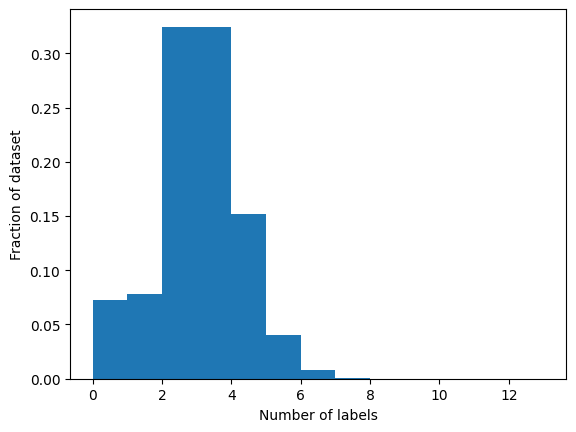

In [95]:
import matplotlib.pyplot as plt

%matplotlib inline


def plot_label_frequency(L):
    plt.hist((L != ABSTAIN).sum(axis=1), density=True, bins=range(L.shape[1]))
    plt.xlabel("Number of labels")
    plt.ylabel("Fraction of dataset")
    plt.show()


plot_label_frequency(L_train)

We see that over half of our `train` dataset data points have 2 or fewer labels from LFs. Fortunately, the labels we do have can be used to train a classifier over the review text directly, allowing this final machine learning model to generalize beyond what our labeling functions label.

Our goal is now to convert the labels from our LFs into a single _noise-aware_ probabilistic (or confidence-weighted) label per data point.
A simple baseline for doing this is to take the majority vote across the LFs for each data point.
However, different LFs have different accuracies, so giving them all equal weight is not ideal.
Instead, we'll use Snorkel's `LabelModel` to learn how to weight each LF for sentiment analysis.

In [96]:
from snorkel.labeling.model import MajorityLabelVoter

majority_model = MajorityLabelVoter()
preds_train = majority_model.predict(L=L_train)

In [97]:
preds_train

array([ 1,  1, -1, ...,  1,  1,  1], shape=(4000,))

However, as we can see from the summary statistics of our LFs in the previous section, they have varying properties and should not be treated identically. In addition to having varied accuracies and coverages, LFs may be correlated, resulting in certain signals being overrepresented in a majority-vote-based model. To handle these issues appropriately, we will instead use a more sophisticated Snorkel `LabelModel` to combine the outputs of the LFs.

This model will ultimately produce a single set of noise-aware training labels, which are probabilistic or confidence-weighted labels. We will then use these labels to train a classifier for our task. For more technical details of this overall approach, see our [NeurIPS 2016](https://arxiv.org/abs/1605.07723) and [AAAI 2019](https://arxiv.org/abs/1810.02840) papers. For more info on the API, see the [`LabelModel` documentation](https://snorkel.readthedocs.io/en/master/packages/_autosummary/labeling/snorkel.labeling.model.label_model.LabelModel.html#snorkel.labeling.model.label_model.LabelModel).

Note that no gold labels are used during the training process.
The only information we need is the label matrix, which contains the output of the LFs on our training set.
The `LabelModel` is able to learn weights for the labeling functions using only the label matrix as input.
We also specify the `cardinality`, or number of classes.

In [98]:
from snorkel.labeling.model import LabelModel

label_model = LabelModel(cardinality=2, verbose=True)
label_model.fit(L_train=L_train, n_epochs=500, log_freq=100, seed=123)

INFO:root:Computing O...
INFO:root:Estimating \mu...
  0%|          | 0/500 [00:00<?, ?epoch/s]INFO:root:[0 epochs]: TRAIN:[loss=1.396]
INFO:root:[100 epochs]: TRAIN:[loss=0.003]
INFO:root:[200 epochs]: TRAIN:[loss=0.002]
 43%|████▎     | 217/500 [00:00<00:00, 2164.48epoch/s]INFO:root:[300 epochs]: TRAIN:[loss=0.002]
INFO:root:[400 epochs]: TRAIN:[loss=0.002]
100%|██████████| 500/500 [00:00<00:00, 2746.93epoch/s]
INFO:root:Finished Training


In [99]:
majority_acc = majority_model.score(L=L_test, Y=Y_test, tie_break_policy="random")[
    "accuracy"
]
print(f"{'Majority Vote Accuracy:':<25} {majority_acc * 100:.1f}%")

label_model_acc = label_model.score(L=L_test, Y=Y_test, tie_break_policy="random")[
    "accuracy"
]
print(f"{'Label Model Accuracy:':<25} {label_model_acc * 100:.1f}%")

Majority Vote Accuracy:   56.9%
Label Model Accuracy:     52.3%


The majority vote model or more sophisticated `LabelModel` could in principle be used directly as a classifier if the outputs of our labeling functions were made available at test time.
However, these models (i.e. these re-weighted combinations of our labeling function's votes) will abstain on the data points that our labeling functions don't cover (and additionally, may require slow or unavailable features to execute at test time).
In the next section, we will instead use the outputs of the `LabelModel` as training labels to train a discriminative classifier **which can generalize beyond the labeling function outputs** to see if we can improve performance further.
This classifier will also only need the text of the review to make predictions, making it much more suitable for inference over unseen reviews.
For more information on the properties of the label model, see the [Snorkel documentation](https://snorkel.readthedocs.io/en/master/packages/_autosummary/labeling/snorkel.labeling.model.label_model.LabelModel.html#snorkel.labeling.model.label_model.LabelModel).

Let's briefly confirm that the labels the `LabelModel` produces are indeed probabilistic in nature.
The following histogram shows the confidences we have that each data point has the label POSITIVE.
The plot highlights that we get a broad range of probability estimates rather than just a hard label.

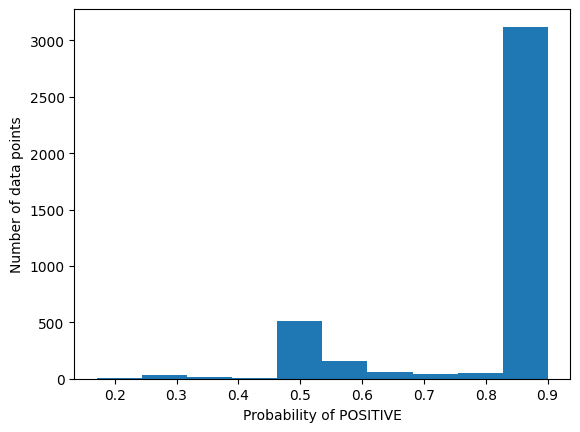

In [100]:
def plot_probabilities_histogram(Y):
    plt.hist(Y, bins=10)
    plt.xlabel("Probability of POSITIVE")
    plt.ylabel("Number of data points")
    plt.show()


probs_train = label_model.predict_proba(L=L_train)
plot_probabilities_histogram(probs_train[:, POSITIVE])

### Filtering out unlabeled data points

As we saw earlier, some of the data points in our `train` set received no labels from any of our LFs.
These data points convey no supervision signal and tend to hurt performance, so we filter them out before training using a
[built-in utility](https://snorkel.readthedocs.io/en/master/packages/_autosummary/labeling/snorkel.labeling.filter_unlabeled_dataframe.html#snorkel.labeling.filter_unlabeled_dataframe).

In [101]:
from snorkel.labeling import filter_unlabeled_dataframe

df_train_filtered, probs_train_filtered = filter_unlabeled_dataframe(
    X=df_train, y=probs_train, L=L_train
)

## 5. Training a Classifier

In this final section of the tutorial, we'll use the probabilistic training labels we generated in the last section to train a classifier for our task.
**The output of the Snorkel `LabelModel` is just a set of labels which can be used with most popular libraries for performing supervised learning, such as TensorFlow, Keras, PyTorch, Scikit-Learn, Ludwig, and XGBoost.**
In this tutorial, we use the well-known library [Scikit-Learn](https://scikit-learn.org).
**Note that typically, Snorkel is used (and really shines!) with much more complex, training data-hungry models, but we will use Logistic Regression here for simplicity of exposition.**

### Featurization

**Note:** An ML model requires numerical features. So, we convert the reviews (text format) into numerical format using one of the many methods called "bag of n-grams". You will learn more about such methods and representations in Natural Language Processing (NLP).

For simplicity and speed, we use a simple "bag of n-grams" feature representation: each data point is represented by a one-hot vector marking which words or 2-word combinations are present in the review text.

In [102]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(ngram_range=(1, 5))
X_train = vectorizer.fit_transform(df_train_filtered.text.tolist())
X_test = vectorizer.transform(df_test.text.tolist())

### Scikit-Learn Classifier

As we saw in Section 4, the `LabelModel` outputs probabilistic (float) labels.
If the classifier we are training accepts target labels as floats, we can train on these labels directly (see describe the properties of this type of "noise-aware" loss in our [NeurIPS 2016 paper](https://arxiv.org/abs/1605.07723)).

If we want to use a library or model that doesn't accept probabilistic labels (such as Scikit-Learn), we can instead replace each label distribution with the label of the class that has the maximum probability.
This can easily be done using the
[`probs_to_preds` helper method](https://snorkel.readthedocs.io/en/master/packages/_autosummary/utils/snorkel.utils.probs_to_preds.html#snorkel.utils.probs_to_preds).
We do note, however, that this transformation is lossy, as we no longer have values for our confidence in each label.

In [103]:
from snorkel.utils import probs_to_preds

preds_train_filtered = probs_to_preds(probs=probs_train_filtered)

We then use these labels to train a classifier as usual.

In [104]:
probs_train_filtered

array([[0.15400789, 0.84599211],
       [0.13942295, 0.86057705],
       [0.15400789, 0.84599211],
       ...,
       [0.13078905, 0.86921095],
       [0.15260273, 0.84739727],
       [0.16920932, 0.83079068]], shape=(3711, 2))

In [105]:
from sklearn.linear_model import LogisticRegression

sklearn_model = LogisticRegression(C=1e3, solver="liblinear")
sklearn_model.fit(X=X_train, y=preds_train_filtered)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1000.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'liblinear'
,max_iter,100
,multi_class,'deprecated'


In [106]:
print(f"Test Accuracy: {sklearn_model.score(X=X_test, y=Y_test) * 100:.1f}%")

Test Accuracy: 50.0%


**We observe an additional boost in accuracy over the `LabelModel` by multiple points! This is in part because the discriminative model generalizes beyond the labeling function's labels and makes good predictions on all data points, not just the ones covered by labeling functions.
By using the label model to transfer the domain knowledge encoded in our LFs to the discriminative model,
we were able to generalize beyond the noisy labeling heuristics**.

## Summary

In this tutorial, we accomplished the following:
* We introduced the concept of Labeling Functions (LFs) and demonstrated some of the forms they can take.
* We used the Snorkel `LabelModel` to automatically learn how to combine the outputs of our LFs into strong probabilistic labels.
* We showed that a classifier trained on a weakly supervised dataset can outperform an approach based on the LFs alone as it learns to generalize beyond the noisy heuristics we provide.

### Next Steps

If you enjoyed this tutorial and you've already checked out the [Getting Started](https://snorkel.org/get-started/) tutorial, check out the [Tutorials](https://snorkel.org/use-cases/) page for other tutorials that you may find interesting, including demonstrations of how to use Snorkel

* As part of a [hybrid crowdsourcing pipeline](https://snorkel.org/use-cases/crowdsourcing-tutorial)
* For [visual relationship detection over images](https://snorkel.org/use-cases/visual-relation-tutorial)
* For [information extraction over text](https://snorkel.org/use-cases/spouse-demo)
* For [data augmentation](https://snorkel.org/use-cases/02-positive-data-augmentation-tutorial)

and more!
You can also visit the [Snorkel website](https://snorkel.org) or [Snorkel API documentation](https://snorkel.readthedocs.io) for more info!